# Diagnosing breast cancer using machine learning algorithms

*The main purpose of writing this notebook was for me to get familiar with Python and its libraries focused on machine learning.*

Tomáš Chobola, 2019

### 1. Introduction

This notebook describes how to use machine learning algorithms to classify breast cancer based on Breast Cancer Wisconsin (Diagnostic) Data Set from UCI Machine Learning Repository. The notebook is accompanied by an application that uses kNN algorithm for making predictions based on user input data.

Let's start by importing the data as numpy array.

In [42]:
%matplotlib notebook
import numpy as np
import random
random.seed(42)

In [43]:
data_array = np.genfromtxt('./breast_cancer_dataset.csv', delimiter=',', dtype='float64, U1, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64')
tmp = np.array([list(elem) for elem in data_array])

In [44]:
print(data_array[0])

(842302., 'M', 17.99, 10.38, 122.8, 1001., 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019., 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189)


The array contains identification number and classificition of the instance in the first two columns. For the analysis and processing I do not need the identification numbers so I will delete them. Furthermore I need to extract the classification values so I can analyse the classification of the data. 

In [37]:
tmp = np.delete(tmp, 0, 1)
results_array = tmp[:,0]
tmp = np.delete(tmp, 0, 1)
data_array = tmp.astype(np.float)

Now I have two arrays, results_array coresponds to the categorization and data_array coresponds to the parameters of the elements.

In [38]:
print('benign instances:', np.count_nonzero(results_array == 'B'), ',', 'malignant instances:', np.count_nonzero(results_array == 'M'))

benign instances: 357 , malignant instances: 212


In [39]:
print(data_array)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [40]:
print('number of instances =', len(data_array))

number of instances = 569


The data_array consists of 569 instances of atributes of digitized image of a fine needle aspirate (FNA) of a breast mass. According to the UCI Machine Learning Repository the first ten values describe radius (mean of distances from center to points on the perimeter), texture (standard deviation of gray-scale values), perimeter, area, smoothness (local variation in radius lengths), compactness (perimeter^2 / area - 1.0), concavity (severity of concave portions of the contour), concave points (number of concave portions of the contour), symmetry and fractal dimension ("coastline approximation" - 1). The reamining values are the mean, standard error and "worst" or largest (mean of the three largest values) of these features.

Now that I have the data imported I can create scatter plot of two features so I can visualise the distribution.

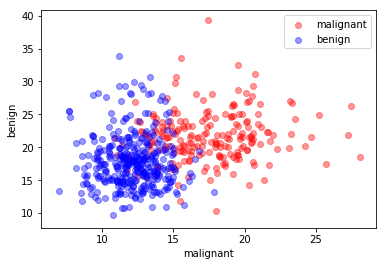

In [41]:
import matplotlib.pyplot as plt

x_values_M = []
y_values_M = []
x_values_B = []
y_values_B = []

for i in range(len(data_array)):
    if results_array[i] == 'M':
        x_values_M.append(data_array[i][0])
        y_values_M.append(data_array[i][1])
    else:
        x_values_B.append(data_array[i][0])
        y_values_B.append(data_array[i][1])
        
plt.scatter(x_values_M, y_values_M, color='red', label='malignant', alpha=0.4)
plt.scatter(x_values_B, y_values_B, color='blue', label='benign', alpha=0.4)

plt.xlabel('malignant')
plt.ylabel('benign')
plt.legend(loc = 1)
plt.show()

Of course the number of atributes is much higher since I am working in 30-dimensional space and not in 2-dimensional space.

### 2. Using the k-nearest neighbours algorithm
The kNN algorithm is one of the most commonly used machine learning algorithms. It is mainly used for classification and regression. The classification is based on k, which is number of nearest neighbours which are analysed and used for classification of a new object.

For presentation purposes I am going to create a synthetic dataset with two clusters and two features.

<IPython.core.display.Javascript object>


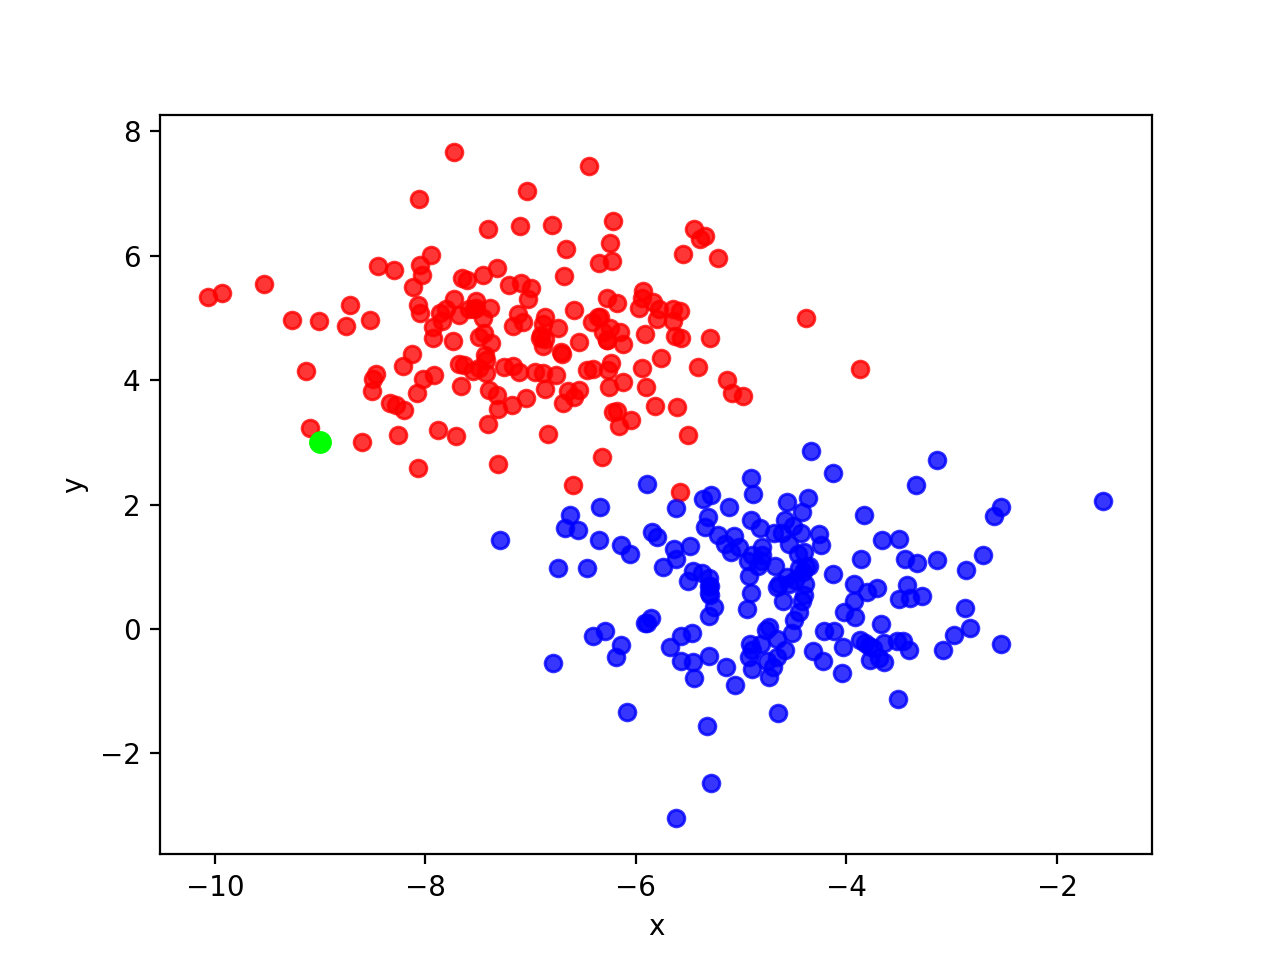

In [31]:
from sklearn.datasets.samples_generator import make_blobs

x, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=1, random_state=12)
plt.scatter(x[y == 0, 0], x[y == 0, 1], color="red", alpha=0.4)
plt.scatter(x[y == 1, 0], x[y == 1, 1], color="blue", alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

This generated scatter plot shows two clusters distinguished by the color. For demonstration purposes I will use those cluster.
Let's say there is a new elements with features x = -9 and y = 3. How will I decide if the element will be red or blue?

In [33]:
plt.scatter(x[y == 0, 0], x[y == 0, 1], color="red", alpha=0.4)
plt.scatter(x[y == 1, 0], x[y == 1, 1], color="blue", alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter([-9],[3], color="lime", s=50)
plt.show()

The green point is closest to the red cluster. If I say that the k value will be 5, then I can see that if I choose five closest points to the green element, all of them will be red. That means that the green point would be classified as red. If for example three out of the five closest neighbours are blue and the remaining two are red, the object will be classified as blue since the classification is based on majority function.

For humans it can be easy to classify objects based on their position in 2-dimensional or 3-dimensional space just by looking at the plots. For computers however, the task is a little more complicated. The kNN algorithm uses distance functions to calculate the distance between objects. Then it chooses the k closest objects and classifies it accordingly. Thanks to distance function I can calculate distance of objects in space with much higher dimensionality than just 2d and 3d. Euclidian metric is often used to calculate the distance between objects.

In [11]:
from IPython.display import Math
Math(r'dist(A,B)=\sqrt\frac{\sum_{i=1}^{m}(x_i - y_i)^2}{m}, A=(x_1, x_2, ..., x_m), B=(y_1, y_2, ..., y_m)')

<IPython.core.display.Math object>

The m value in the equation represents the dimension of the space.

Now that I know how the algorithm works I can use it to make predictions about new instances. I am going to split the original UCI dataset so two thirds are used for learning and one third for validating.

In [12]:
import math

# Splits data into two datasets, first part is intended for learning and second part is intended for validation.
def split_data(data_array, results_array, training_size = 0.67):
    training_data = [] # training data (first 67% of the original dataset) = first part
    training_results = [] # training data results
    validation_data = [] # validation data (remaining 33% of the original dataset) = second part
    validation_results = [] # validation data results

    training_length = math.ceil(len(data_array) * training_size)
    for i in range(training_length):
        training_data.append(data_array[i])
        training_results.append(results_array[i])

    for i in range(len(data_array) - training_length):
        validation_data.append(data_array[i + training_length])
        validation_results.append(results_array[i + training_length])

    training_data = np.array(training_data)
    training_results = np.array(training_results)
    validation_data = np.array(validation_data)
    validation_results = np.array(validation_results)

    return training_data, training_results, validation_data, validation_results

In [13]:
training_data, training_results, validation_data, validation_results = split_data(data_array, results_array)

The sklearn library already offers implemented classifier so I am going to use it. The precision and quality of the classifier is based on the k value. In order to get the best results I will pick a value in range [1,50] that gives the best results.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

def best_k():
    accuracy = 0
    k = 1

    for i in range(1, 50):
        classifier = KNeighborsClassifier(n_neighbors = i)
        classifier.fit(training_data, training_results)
        if classifier.score(validation_data, validation_results) > accuracy:
            accuracy = classifier.score(validation_data, validation_results)
            k = i

    return k

In [15]:
k = best_k()
classifier = KNeighborsClassifier(n_neighbors = k)
classifier.fit(training_data, training_results)

print('k =', k)
print('accuracy =', classifier.score(validation_data, validation_results))

k = 24
accuracy = 0.9572192513368984


The best k value in this case is 24 and it gives accuracy around 95.72% on the validation data. The classifier is set so it can be used for making predictions.

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_results, classifier.predict(validation_data))
print(cm)

[[139   5]
 [  3  40]]


From the confusion matrix I can see the high accuracy of the model since strong majority of the instances was classified correctly.

In [17]:
instance_a = [17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189]

instance_b = [11.94,18.24,75.71,437.6,0.08261,0.04751,0.01972,0.01349,0.1868,0.0611,0.2273,0.6329,1.52,17.47,0.00721,0.00838,0.01311,0.008,0.01996,0.002635,13.1,21.33,83.67,527.2,0.1144,0.08906,0.09203,0.06296,0.2785,0.07408]

instance_a = np.array(instance_a).reshape(1,-1).astype(np.float64)
instance_b = np.array(instance_b).reshape(1,-1).astype(np.float64)

In [18]:
print('Prediction of instance A:', classifier.predict(instance_a))
print('Prediction of instance B:', classifier.predict(instance_b))

Prediction of instance A: ['M']
Prediction of instance B: ['B']


From the predictions I can see that the instance A was classified as malignant and instance B was classified as benign which corresponds to the classifications that were stated in the original dataset. 

### 3. Using the Gaussian Naive Bayes algorithm

In [19]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB(priors=None, var_smoothing=1e-09)
classifier.fit(training_data, training_results)

GaussianNB(priors=None, var_smoothing=1e-09)

In [20]:
print('accuracy =', classifier.score(validation_data, validation_results))

accuracy = 0.9625668449197861


When testing the classifier on the validation data the model peaks with accuracy around 96% which is a little more accurate than the kNN model.

In [21]:
cm = confusion_matrix(validation_results, classifier.predict(validation_data))
print(cm)

[[140   4]
 [  3  40]]


From the confusion matrix I can see that the error in classification is the same as in the previous section where I was using the k-nearest neighbours algorithm. Even though the percentual accuracy is a little bit higher it does not make a difference because of the small size of the dataset.

In [22]:
print('Prediction of instance A:', classifier.predict(instance_a))
print('Prediction of instance B:', classifier.predict(instance_b))

Prediction of instance A: ['M']
Prediction of instance B: ['B']


From the predictions I can see that the instance A was classified as malignant and instance B was classified as benign which corresponds to the classifications that were stated in the original dataset. 

### 4. Using neural network

The final classification process I am presenting is using neural network to analyze the data. 

The neural network is a system of connected nodes which are producing output values based on input. Those values are propagated through the network to the last node that produces the resulting value. The neural network works in a similar way as neurons in a biological brain. The nodes (or neurons) are connected to each other by edges and each edge has a weight. The processes happening inside the nodes and the weights of the edges are the main source of the predictions. I am using Sequential from keras which uses backpropagation algorithm for altering the network in a particular way so it can make precise predictions.

In [23]:
from keras import Sequential
from keras.layers import Dense
from numpy.random import seed
seed(142857)

Using TensorFlow backend.


After importing the libraries I am going to define the neuaral network. The input layer takes in 30 values which is the dimension of the space I am working in. Next I added first and second hidden layer with 16 and 8 nodes. Those two layers are using rectifier as activation function for its faster learning rate than with sigmoid function:

In [24]:
Math(r'f(x)=max(0,x)')

<IPython.core.display.Math object>

The output layer is than using classic sigmoid function because works well for classification problems:

In [25]:
Math(r'S(x)=\frac{1}{1+e^{-x}}')

<IPython.core.display.Math object>

In [26]:
network = Sequential()
# first hidden layer
network.add(Dense(16, activation='relu', kernel_initializer='random_normal', input_dim=30))
# second hidden layer
network.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
# output layer
network.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

network.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


Here is visualization of the compiled neural network I made with online tool [NN-SVG](http://alexlenail.me/NN-SVG/index.html). 

After compiling the neural network I need to transfer the result array so the network can work with numeric values. Next, the network will be trained on the training dataset in 100 iterations.

In [27]:
training_results = np.where(training_results == 'M', 1, training_results)
training_results = np.where(training_results == 'B', 0, training_results)

network.fit(training_data, training_results, batch_size=10, epochs=100, verbose=0)

Instructions for updating:
Use tf.cast instead.


Now that the training is done I can evaluate the network.

In [28]:
evaluation = network.evaluate(training_data, training_results)
print(evaluation)

382/382 [==============================] - 0s 137us/step
[0.17270400792516338, 0.9319371705904057]


The neural network has accuracy around 93% (the value fluctuates because of the randomness of the NN learning algorithm and is different with every iteration) based on the training data. This result is quite high and I can trust it that the classifications will be accurate. 

In order to see the precision on the validation set I am going to use a confusion matrix.

In [29]:
validation_results = np.where(validation_results == 'M', 1, validation_results)
validation_results = np.where(validation_results == 'B', 0, validation_results)
validation_results = np.array(validation_results).reshape(-1,1).astype(np.float64)

prediction = network.predict(validation_data)
prediction = prediction > 0.5

cm = confusion_matrix(validation_results, prediction)
print(cm)

[[140   4]
 [  4  39]]


The confusion matrix is very similiar to the ones from prevoius models. To get the accuracy score I simply use the accuracy_score function from sklearn library.

In [30]:
from sklearn.metrics import accuracy_score

print('accuracy =', accuracy_score(validation_results, prediction))

accuracy = 0.9572192513368984


The neural network has accuracy of 95.72% on the validation data.

### 5. Conclusion
After testing the k-nearest neighbours algoritm, the Gaussian Naive Bayes algorithm and simple neural network on UCI dataset made out of instances of atributes of digitized image of a fine needle aspirate (FNA) of a breast mass I can say that all three of them performed significantly well. Although the dataset is small and the number of data is not sufficient for any real-life application. On a positive side of things the classification models could be used on different datasets and when properly set they could produce accurate and meaningful predictions.